### Document Clustering
NEW REPLACEMENT script.

Since downloading a wikipedia dump, I've started my code over from scratch. `reformat.py` contains some important code to preprocess the outputted wiki dump from the wikiextractor I used.

This notebook will open a few sample JSON files and attempt to cluster them.

In [1]:
import json
import glob

In [2]:
wiki_articles = []
for x in glob.glob('data/wiki*.json'):
    new_articles = json.load(open(x))['articles']
    wiki_articles += new_articles
wiki_articles[0].keys()

dict_keys(['title', 'text', 'url', 'id'])

In [3]:
for article in wiki_articles[:5]:
    for key, val in article.items():
        if key != 'text':
            print(key, ':', val)

title : Anarcho-capitalism
url : https://en.wikipedia.org/wiki?curid=1023
id : 1023
title : August 9
url : https://en.wikipedia.org/wiki?curid=1027
id : 1027
title : Aristophanes
url : https://en.wikipedia.org/wiki?curid=1028
id : 1028
title : Albert Schweitzer
url : https://en.wikipedia.org/wiki?curid=1029
id : 1029
title : Austrian School
url : https://en.wikipedia.org/wiki?curid=1030
id : 1030


Looks like my JSON conversions worked! The only problem now, is finding links that are actually related to one another so I can effectively test my clustering algorithm. I don't have my data pre-organized by topics...

We'll wee what we can visualize with T-SNE first.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
wiki_articles_text = [x['text'] for x in wiki_articles]
tfidf_vectors = tfidf.fit_transform(wiki_articles_text)

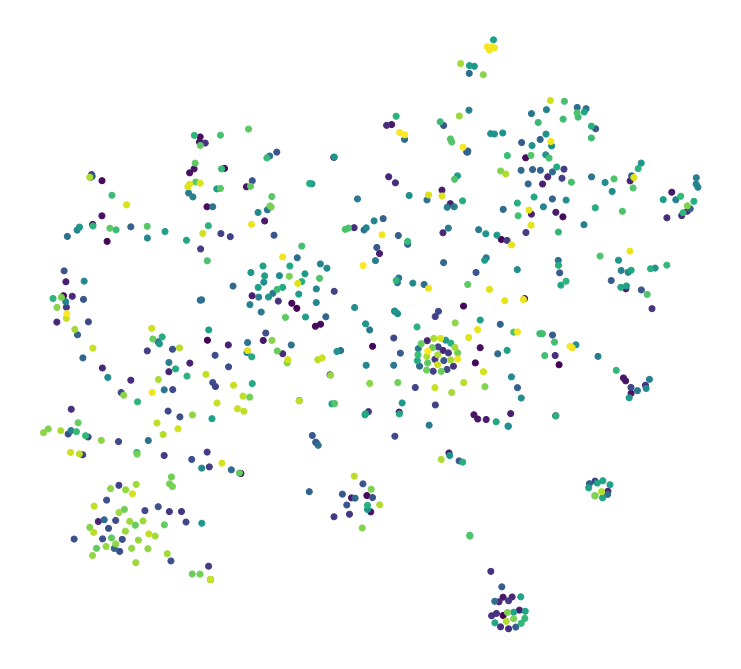

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_vectors)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X_reduced)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=[i for i in range(len(wiki_articles))], marker="o", label=[x for x in wiki_articles])

plt.show()

In [6]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_vectors)


In [8]:
from sklearn.cluster import KMeans
num_clusters = 4

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_vectors)

clusters = km.labels_.tolist()

CPU times: user 2.94 s, sys: 0 ns, total: 2.94 s
Wall time: 2.99 s


In [9]:
from sklearn.externals import joblib
joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()